# Analysing Slow Zones in their broader spatial context

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scale for maps
from matplotlib_scalebar.scalebar import ScaleBar
# Personalised legends for maps
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import os

import geopandas as gpd
import rasterio as rio
import fiona
import contextily
import osmnx
from shapely import geometry

In [6]:
# Set working directory
os.chdir("/Users/unaioyon/Desktop/masters_thesis/data/fra")

## 0. Geographic layers

In [3]:
# Import basic data
zones = gpd.read_file("zones_30/zones-30.shp")
ref = gpd.read_file("traffic/referentiel/referentiel-comptages-routiers.shp")
arr = gpd.read_file("arrondissements/arrondissements.shp")
eau = gpd.read_file("eau/plan-de-voirie-voies-deau.shp")
iris = gpd.read_file("iris/geo/iris_paris_2022/1_DONNEES_LIVRAISON_2022-05-00266/IRIS-GE_2-0_SHP_LAMB93_D075-2022/IRIS_GE.SHP")
quartier = gpd.read_file("quartiers/quartier_paris.shp")
kinder = gpd.read_file("schools/maternelles/etablissements-scolaires-maternelles.shp")
schools = gpd.read_file("schools/elementary/etablissements-scolaires-ecoles-elementaires.shp")
highschools = gpd.read_file("schools/colleges/etablissements-scolaires-colleges.shp")
arrets = gpd.read_file("transport/idf_mobilites/arrets/arrets_paris.geojson")
zcorr = gpd.read_file("transport/idf_mobilites/z_arrets/z_arrets_paris.shp")
zarr = gpd.read_file("transport/idf_mobilites/z_correspondances/z_correspondances_paris.shp")

In [4]:
# Import DV3F
dv3f = gpd.read_file("/Users/unaioyon/Desktop/DV3F_new/mod/mutations_paris.shp")

In [5]:
# Relevant modifications to the data

# Generate centroid & put as active geometry for the following sections
dv3f["centroid"] = dv3f["geometry"].centroid
dv3f.set_geometry("centroid", inplace=True)

In [6]:
# Changing CRS
zones.to_crs("EPSG:2154", inplace = True)
arr.to_crs("EPSG:2154", inplace = True)
quartier.to_crs("EPSG:2154", inplace = True)
iris.to_crs("EPSG:2154", inplace = True) # no change because it is the same it has specified, but with diff. name
schools.to_crs("EPSG:2154", inplace = True)
highschools.to_crs("EPSG:2154", inplace = True)
eau.to_crs("EPSG:2154", inplace = True)
arrets.to_crs("EPSG:2154", inplace = True)
kinder.to_crs("EPSG:2154", inplace = True)

## 1. Assigning transactions to IRIS/Slow Zones/Arrondissements

In order to assign transaction to different regions, I proceed as follows:
 * 1. I transform all the dataframes to a comparable CRS. Notably, some of them are in the geographic CRS EPSG:4326, while the IRIS and the DV3F data are in the projected EPSG:2154. Thus, I compute the centroid of the cadaster parcels for DV3F in the original CRS, and then transform everything to EPSG:2154.
 * 2. I employ gpd.GeoDataFrame.within() to iterate over any second dataframe to classify observations. The centroid is used to make sure an observation is classified to a given region (where its centroid is located) regardless of it overlapping more than one region. **This gives scope for robustness checks, in case there are a lot of transactions happening in parcels with overlap in the frontier of two zones, notably between a slow zone and a no slow zone where there is a traffic sensor. Other methods like overlaps(), intersects() etc. may not give a unique answer, so scope for discussion here.**
 * 3. The newly created variables are stored as objects, in order to create graphs and group_by more easily.

In [7]:
# Creating the variables
dv3f.insert(50, "slow_zone", pd.Series([], dtype = "object"))
dv3f.insert(51, "slow_zone_year", pd.Series([], dtype = "object"))
# dv3f.insert(57, "slow_zone_intersect", pd.Series([]))
dv3f.insert(52, "arr", pd.Series([], dtype = "object"))
dv3f.insert(53, "arr_code", pd.Series([], dtype = "object"))
# dv3f.insert(58, "arr_intersect", pd.Series([]))
dv3f.insert(54, "iris", pd.Series([], dtype = "object"))
dv3f.insert(55, "iris_code", pd.Series([], dtype = "object"))
dv3f.insert(56, "iris_name", pd.Series([], dtype = "object"))
# dv3f.insert(59, "iris_intersect", pd.Series([]))

In [8]:
dv3f.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 427694 entries, 0 to 427693
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   idmutation      427694 non-null  float64 
 1   idmutinvar      427694 non-null  object  
 2   idopendata      427694 non-null  object  
 3   idnatmut        427694 non-null  float64 
 4   codservch       324989 non-null  object  
 5   refdoc          324989 non-null  object  
 6   datemut         427694 non-null  object  
 7   anneemut        427694 non-null  float64 
 8   moismut         427694 non-null  float64 
 9   coddep          427694 non-null  float64 
 10  libnatmut       427694 non-null  object  
 11  vefa            427694 non-null  int64   
 12  valeurfonc      427544 non-null  float64 
 13  nblot           427694 non-null  float64 
 14  nbcomm          427694 non-null  float64 
 15  l_codinsee      427694 non-null  object  
 16  nbsection       427694 non-nul

In [9]:
%%time
# Classifying SLOW ZONES
# There are 9 zones with missing geometries, so these ones will not have any transaction inside
zones_non_na = zones[zones["geometry"].isna() == False].copy()

for i in zones_non_na.index:
    dv3f.loc[dv3f["centroid"].within(zones.loc[i, "geometry"]), "slow_zone"] = zones.loc[i, "nom_zca"]
    dv3f.loc[dv3f["centroid"].within(zones.loc[i, "geometry"]), "slow_zone_year"] = zones.loc[i, "year"]
    dv3f.loc[dv3f["centroid"].within(zones.loc[i, "geometry"]), "slow_zone_name"] = zones.loc[i, "year"]
    
# Add a dummy equal to 1 if inside a slow zone
dv3f.insert(52, "slow_zone_d", pd.Series([], dtype = "object"))
dv3f["slow_zone_d"] = 0
dv3f.loc[dv3f["slow_zone"].isna() == False, "slow_zone_d"] = 1

CPU times: user 3min 38s, sys: 1.17 s, total: 3min 39s
Wall time: 3min 39s


In [25]:
# Count number of NAs
print(dv3f["slow_zone"].isna().sum()) # 202,112 (i.e. 47% of transactions outside of slow zones. Pretty balanced)
print(dv3f.loc[dv3f["slow_zone"].isna() == False, "slow_zone_year"].isna().sum()) # 30,997 without year of implementation

202112
30997


In [29]:
# Not all zones with available geometry have at least one transaction: 6 of them present none
print(len(zones_non_na["nom_zca"].unique()) == len(dv3f["slow_zone"].unique())-1)
print(len(zones_non_na["nom_zca"].unique()) - (len(dv3f["slow_zone"].unique())-1))

False
6


In [30]:
# Selecting slow zones that have geometry and do not appear in the DV3F dataframe, i.e., have no transactions
# inside them. Plot them against the transactions on the following chunk
zones_no_overlap = zones[(zones["geometry"] != None) & (zones["nom_zca"].isin(dv3f["slow_zone"].unique()) == False)].copy()
zones_no_overlap

nom_zca                   date_arr month  year  \
0                Marché Saint Honoré                        NaN   NaN   NaN   
30                  Avenue de Clichy  2013-08-16 04:00:00+02:00    08  2013   
43                   Joseph Chailley                        NaN   NaN   NaN   
47   Quai André Citroën/Rober Keller  2013-10-25 04:00:00+02:00    10  2013   
54                   Charles Hermite                        NaN   NaN   NaN   
111                     Rue Legendre  2013-08-30 04:00:00+02:00    08  2013   

     type_arr arrdt reglement  \
0         NaN     1   ZONE 30   
30        MDP    17   ZONE 30   
43        NaN    12   ZONE 30   
47   CONJOINT    15   ZONE 30   
54        NaN    18   ZONE 30   
111       MDP    17   ZONE 30   

                                              geometry  
0    POLYGON ((650807.339 6863179.439, 650732.293 6...  
30   POLYGON ((650676.412 6865086.612, 650654.192 6...  
43   POLYGON ((655920.685 6859144.900, 655817.449 6...  
47   POLYGON ((647098.472 6861051.721, 647280.611 6...  
54   POLYGON ((653359.919 6866702.363, 653353.120 6...  
111  POLYGON ((649906.893 6865302.080, 650323.481 6...

<AxesSubplot: >

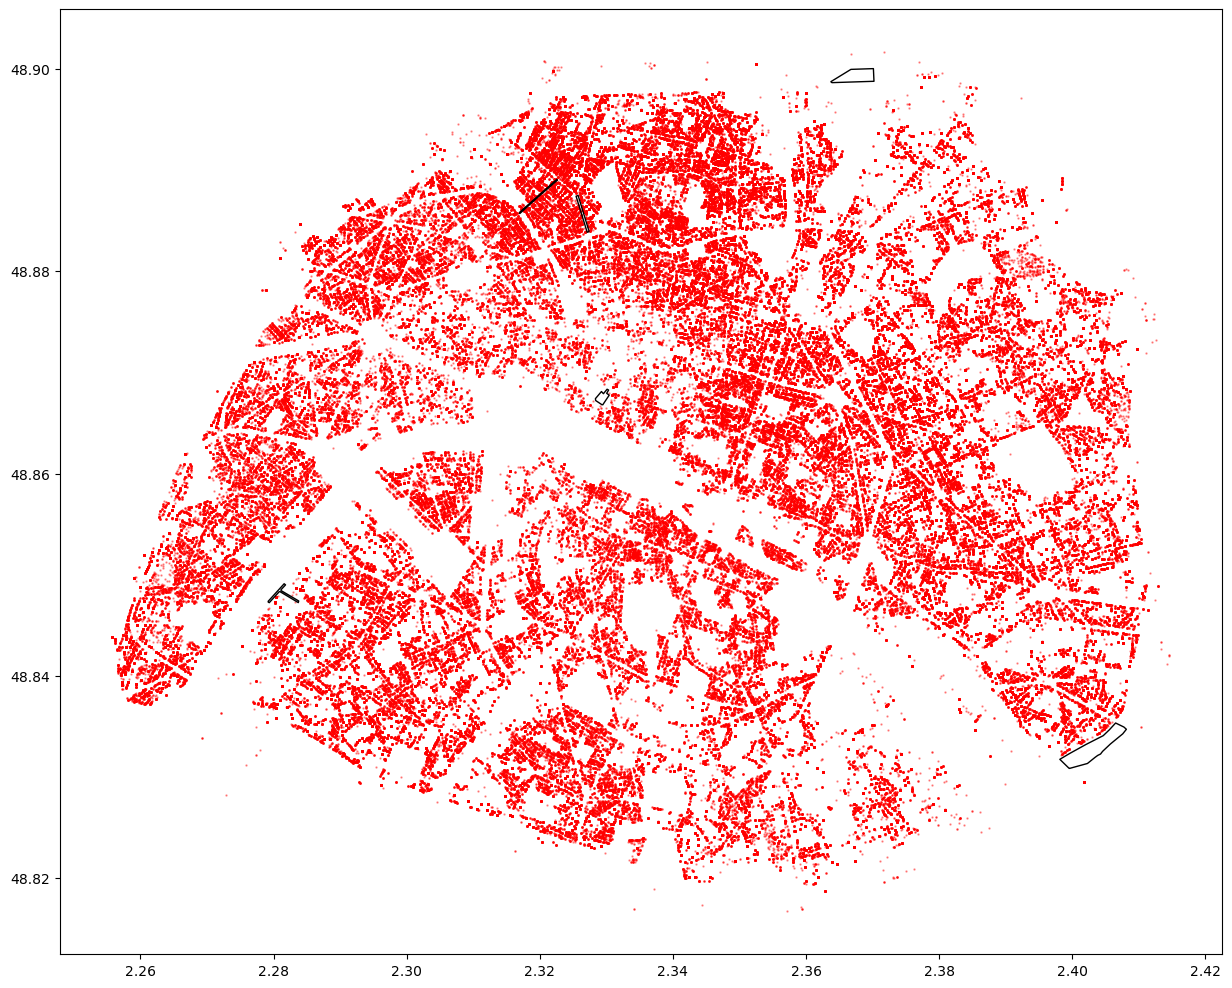

In [214]:
fig, ax = plt.subplots(1, figsize = (15, 15))
dv3f.plot(ax = ax, markersize = 0.5, color = "red", alpha = 0.4)
zones_no_overlap.boundary.plot(ax = ax, linewidth = 1, color = "black")

## In this plot, compared to the one in 1_graphical_analysis, we see some slow zones that are not present because
# we do not know their implementation date. 

In [31]:
%%time
# Classifying ARRONDISSEMENTS

for i in arr.index:
    dv3f.loc[dv3f["centroid"].within(arr.loc[i, "geometry"]), "arr"] = arr.loc[i, "c_ar"]
    dv3f.loc[dv3f["centroid"].within(arr.loc[i, "geometry"]), "arr_code"] = arr.loc[i, "c_arinsee"]

CPU times: user 54.5 s, sys: 261 ms, total: 54.7 s
Wall time: 54.7 s


In [32]:
# 11 NAs which corresponds to the 11 transactions happening in Paris without any geometry
print(dv3f["arr"].isna().sum(), dv3f["arr_code"].isna().sum())
dv3f.loc[dv3f["arr"].isna() == True, "geometry"]

11 11


70996     None
93546     None
93863     None
125433    None
292758    None
342353    None
346375    None
347690    None
395762    None
399462    None
402769    None
Name: geometry, dtype: geometry

In [33]:
print(iris.info())
iris.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   INSEE_COM  992 non-null    object  
 1   NOM_COM    992 non-null    object  
 2   IRIS       992 non-null    object  
 3   CODE_IRIS  992 non-null    object  
 4   NOM_IRIS   992 non-null    object  
 5   TYP_IRIS   992 non-null    object  
 6   geometry   992 non-null    geometry
dtypes: geometry(1), object(6)
memory usage: 54.4+ KB
None


INSEE_COM                   NOM_COM  IRIS  CODE_IRIS          NOM_IRIS  \
0     75116  Paris 16e Arrondissement  6110  751166110        Auteuil 10   
1     75116  Paris 16e Arrondissement  6129  751166129        Auteuil 29   
2     75115  Paris 15e Arrondissement  6006  751156006           Javel 6   
3     75115  Paris 15e Arrondissement  5712  751155712  Saint-Lambert 12   
4     75115  Paris 15e Arrondissement  5910  751155910       Grenelle 10   

  TYP_IRIS                                           geometry  
0        H  POLYGON ((645595.800 6860843.100, 645596.000 6...  
1        H  POLYGON ((646617.600 6861093.200, 646621.400 6...  
2        H  POLYGON ((647311.300 6860097.600, 647317.100 6...  
3        H  POLYGON ((647843.900 6860072.700, 647851.200 6...  
4        H  POLYGON ((647965.200 6861229.200, 648005.000 6...

In [34]:
%%time
# Classifying IRIS

for i in iris.index:
    dv3f.loc[dv3f["centroid"].within(iris.loc[i, "geometry"]), "iris"] = iris.loc[i, "IRIS"]
    dv3f.loc[dv3f["centroid"].within(iris.loc[i, "geometry"]), "iris_code"] = iris.loc[i, "CODE_IRIS"]
    dv3f.loc[dv3f["centroid"].within(iris.loc[i, "geometry"]), "iris_name"] = iris.loc[i, "NOM_IRIS"]

CPU times: user 26min 38s, sys: 8.31 s, total: 26min 46s
Wall time: 26min 48s


In [35]:
# Checking out the result
print(len(dv3f["iris"].unique())-1) # 936 IRIS have transactions
print(dv3f["iris"].isna().sum()) # No NA, meaning all transactions are inside a given IRIS

936
11


In [68]:
# Save the file with geographic information and without it
# Need to convert the other geometry columns to "object"  and "string" first
dv3f["geometry"] = dv3f["geometry"].astype("object")
dv3f["geometry"] = dv3f["geometry"].astype("string")
dv3f.to_file("dv3f_new_variables/dv3f_modified.geojson", index = False)

# Eliminate the geometry variables
# Save it as a csv
dv3f_no_geo = pd.DataFrame(dv3f.iloc[:,0:dv3f.shape[1]-3])
dv3f_no_geo.to_csv("dv3f_new_variables/dv3f_modified.csv", index = False)

In [65]:
gpd.GeoDataFrame.to_file?

**Relevant discussion regarding the IRIS classification**
 * IRIS are much more numerous than slow zones and arrondissements, implying **the probability of a given transaction lying just in the boundary between them is increased** (if taking the centroid, and maximized if using the geometry of the cadastral parcel as the transaction reference). Thus, we may have an interest in pairing within(), overlaps(), touches() and/or intersects() in a for loop, hierarchically using the functions to ensure:
     * a) That we prioritize being inside than just touching an IRIS.
     * b) That there is no overwritting once a given transaction has been clasified (though this should not be a concern when using the centroid).
 * However, the lack of NAs when using within() (apart from the 11 transactions with no reported geometry) makes us think about the desirability of the aforementioned function, which may well suffice to classify transactions.

In [117]:
# Check how many zones there are in each district
zones.groupby("arrdt")["arrdt"].count().sort_values(ascending = False)

arrdt
12    17
20    12
11    11
14    11
18    11
13     8
15     8
17     8
5      7
1      6
4      6
6      5
19     5
2      5
10     5
16     4
7      4
9      4
3      3
8      1
Name: arrdt, dtype: int64

In [22]:
zones.loc[zones["geometry"].isna(), :]

nom_zca                   date_arr    type_arr arrdt  \
12                Paul Appel  2019-02-15 02:00:00+01:00         MDP    14   
52    Porte de MÃ©nilmontant  2010-06-15 04:00:00+02:00  MDP AVEC C    20   
57                  Commerce  2015-08-14 04:00:00+02:00    CONJOINT    15   
83              TÃ©lÃ©graphe  2014-01-14 02:00:00+01:00         MDP    20   
89                    Vosges  2017-09-26 04:00:00+02:00    CONJOINT   NaN   
110                 Maubeuge                        NaN         NaN     9   
128  Bernardins/Saint Victor                        NaN         NaN     5   
134         Maurice d'Ocagne  2019-02-26 02:00:00+01:00         MDP    14   
135                La Plaine                        NaN    CONJOINT    20   

    reglement geometry  year month  
12    ZONE 30     None  2019    02  
52    ZONE 30     None  2010    06  
57    ZONE 30     None  2015    08  
83    ZONE 30     None  2014    01  
89    ZONE 30     None  2017    09  
110   ZONE 30     None   NaN   NaN  
128   ZONE 30     None   NaN   NaN  
134   ZONE 30     None  2019    02  
135   ZONE 30     None   NaN   NaN

In [38]:
zones.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   nom_zca    142 non-null    object  
 1   date_arr   106 non-null    object  
 2   type_arr   108 non-null    object  
 3   arrdt      141 non-null    object  
 4   reglement  142 non-null    object  
 5   geometry   133 non-null    geometry
 6   year       106 non-null    object  
dtypes: geometry(1), object(6)
memory usage: 7.9+ KB


<AxesSubplot: >

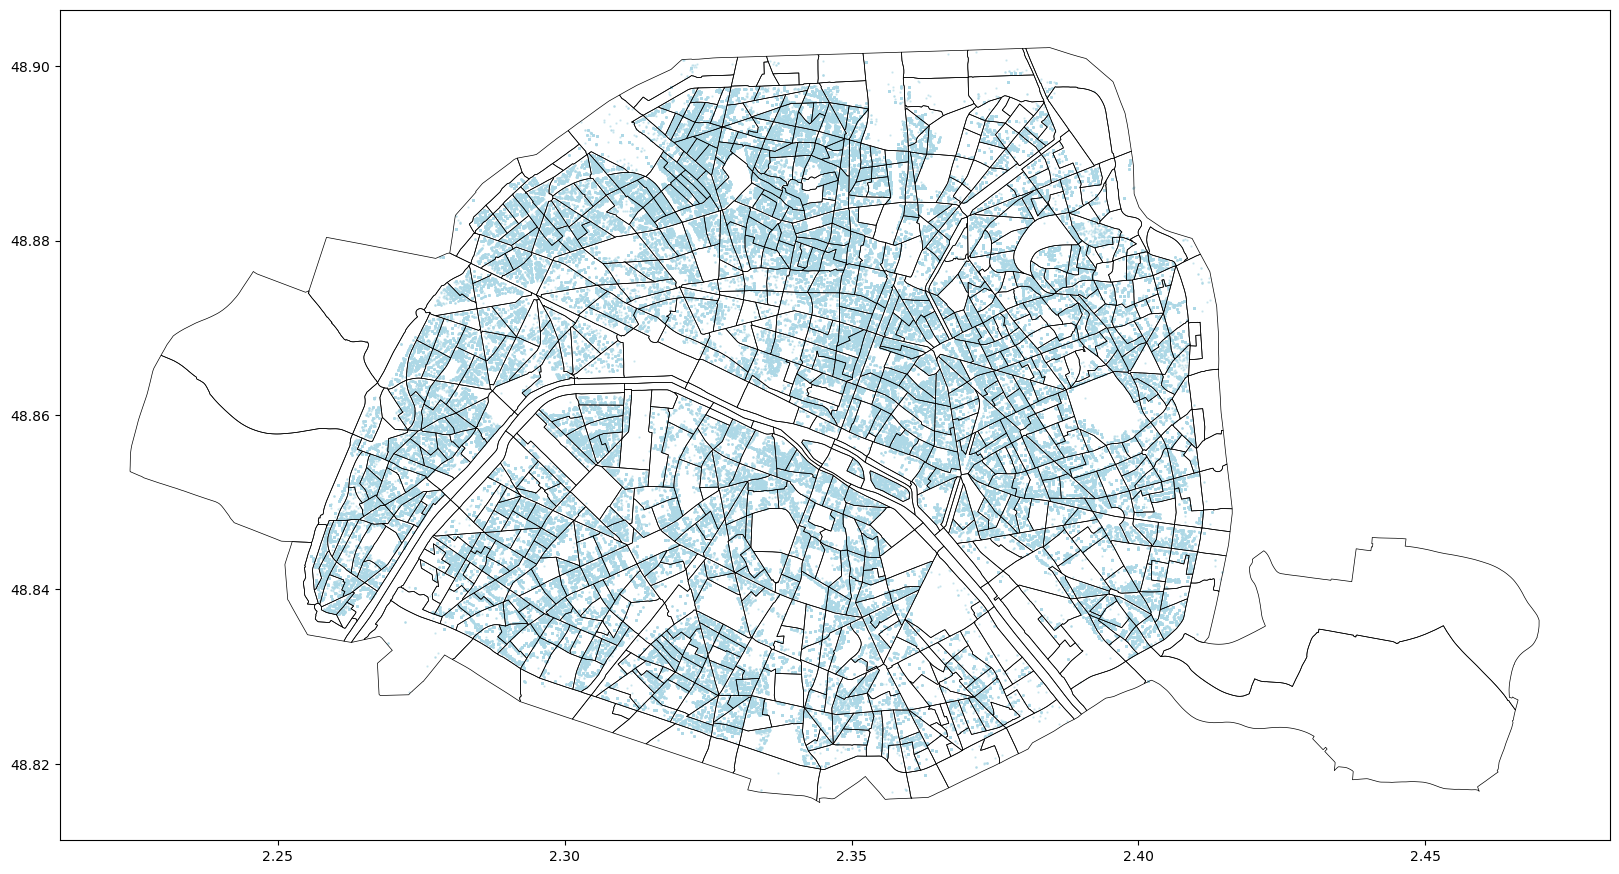

In [27]:
fig, ax = plt.subplots(1, figsize = (20, 20))
dv3f.plot(ax = ax, markersize = 0.5, color = "lightblue", alpha = 0.5)
iris.boundary.plot(ax = ax, linewidth = 0.5, color = "black")

In [93]:
zone_par = zones.loc[zones["geometry"].isna() == False].copy().reset_index()

In [94]:
zone_par

index                nom_zca                   date_arr    type_arr  \
0        0  MarchÃ© Saint HonorÃ©                        NaN         NaN   
1        1                  Eylau  2014-01-14 02:00:00+01:00          PP   
2        2                Sorbier  2010-06-15 04:00:00+02:00  MDP AVEC C   
3        3                Moselle  2010-07-02 04:00:00+02:00  MDP AVEC C   
4        4             Parmentier  2018-08-07 04:00:00+02:00    CONJOINT   
..     ...                    ...                        ...         ...   
128    137                Aqueduc  2010-05-28 04:00:00+02:00         MDP   
129    138          Tombe Issoire  2010-07-02 04:00:00+02:00  MDP AVEC C   
130    139           Saint-Blaise  2013-11-05 02:00:00+01:00    CONJOINT   
131    140         Mairie du IVÃ¨  2019-07-12 04:00:00+02:00    CONJOINT   
132    141              CrÃ©mieux                        NaN         NaN   

    arrdt reglement                                           geometry  year  
0       1   ZONE 30  POLYGON ((2.32942 48.86676, 2.32839 48.86722, ...   NaN  
1      16   ZONE 30  POLYGON ((2.28617 48.86325, 2.28543 48.86332, ...  2014  
2      20   ZONE 30  POLYGON ((2.38750 48.86322, 2.38397 48.86631, ...  2010  
3      19   ZONE 30  POLYGON ((2.37022 48.88294, 2.37090 48.88359, ...  2010  
4      11   ZONE 30  POLYGON ((2.37419 48.86547, 2.36568 48.86711, ...  2018  
..    ...       ...                                                ...   ...  
128    10   ZONE 30  POLYGON ((2.35736 48.87959, 2.35903 48.88280, ...  2010  
129    14   ZONE 30  POLYGON ((2.33482 48.82750, 2.33270 48.82785, ...  2010  
130    20   ZONE 30  POLYGON ((2.40621 48.85280, 2.40548 48.85526, ...  2013  
131     4   ZONE 30  POLYGON ((2.35797 48.85346, 2.35767 48.85353, ...  2019  
132    12   ZONE 30  POLYGON ((2.36839 48.84540, 2.36709 48.84641, ...   NaN  

[133 rows x 8 columns]

In [95]:
par["arr"] = pd.Series([], dtype = "object")

In [96]:
par["geometry"].within(zone_par.loc[15, "geometry"])

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
dtype: bool

In [97]:
for j in zone_par.index:
    par.loc[par["geometry"].within(zone_par.loc[j, "geometry"]), "arr"] = zone_par.loc[j, "nom_zca"]

In [98]:
zone_par.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   index      133 non-null    int64   
 1   nom_zca    133 non-null    object  
 2   date_arr   100 non-null    object  
 3   type_arr   101 non-null    object  
 4   arrdt      133 non-null    object  
 5   reglement  133 non-null    object  
 6   geometry   133 non-null    geometry
 7   year       100 non-null    object  
dtypes: geometry(1), int64(1), object(6)
memory usage: 8.4+ KB


In [88]:
siu = zone_par.loc[zone_par["nom_zca"]=="Vertbois", "geometry"].copy()

In [102]:
zone_par["boundary"] = zone_par.geometry.boundary
zone_par.set_geometry("boundary", inplace=True)

<AxesSubplot: >

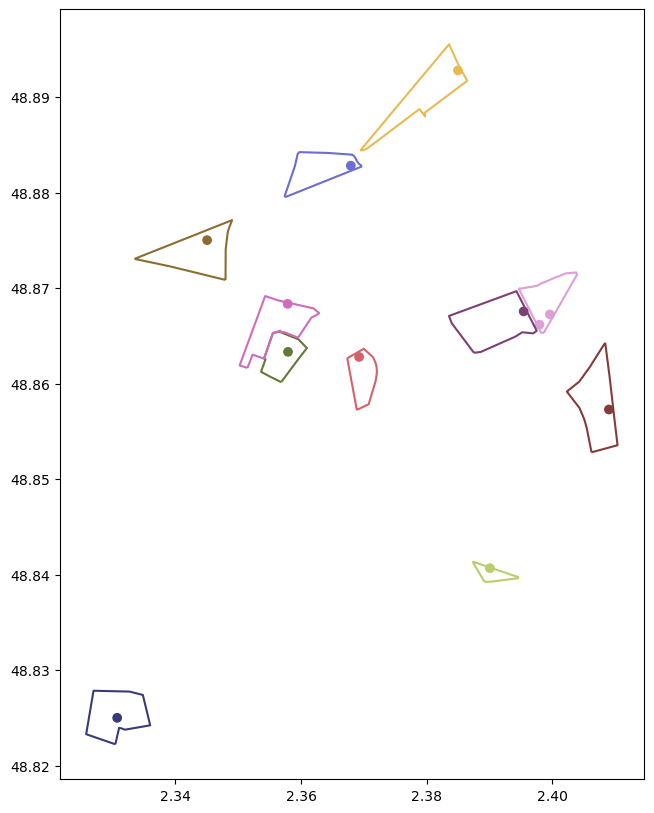

In [114]:
fig, ax = plt.subplots(1, figsize = (10, 10))
zone_par_c.plot(ax = ax, column = "nom_zca", cmap ="tab20b")
par.plot(ax = ax, column = "arr", cmap = "tab20b")

In [109]:
zone_par_c = zone_par.loc[zone_par["nom_zca"].isin(par["arr"])].copy()

In [110]:
zone_par_c

index                  nom_zca                   date_arr    type_arr  \
2        2                  Sorbier  2010-06-15 04:00:00+02:00  MDP AVEC C   
38      39          AlÃ©sia-Sarette  2010-07-02 04:00:00+02:00         MDP   
39      40         Beaubourg Temple  2008-02-08 02:00:00+01:00         MDP   
44      45                 Vertbois  2018-12-11 02:00:00+01:00         MDP   
56      59  Villiers de l'Isle Adam  2013-12-13 02:00:00+01:00    CONJOINT   
65      68                Dugommier  2010-02-16 02:00:00+01:00  MDP AVEC C   
81      85         Saint-SÃ©bastien  2010-04-16 04:00:00+02:00         MDP   
92      97                  Flandre  2014-10-21 04:00:00+02:00    CONJOINT   
107    113      Faubourg Montmartre  2010-06-15 04:00:00+02:00  MDP AVEC C   
128    137                  Aqueduc  2010-05-28 04:00:00+02:00         MDP   
130    139             Saint-Blaise  2013-11-05 02:00:00+01:00    CONJOINT   

    arrdt reglement                                           geometry  year  \
2      20   ZONE 30  POLYGON ((2.38750 48.86322, 2.38397 48.86631, ...  2010   
38     14   ZONE 30  POLYGON ((2.33044 48.82223, 2.32580 48.82329, ...  2010   
39      3   ZONE 30  POLYGON ((2.35683 48.86015, 2.35504 48.86073, ...  2008   
44      3   ZONE 30  POLYGON ((2.35146 48.86164, 2.35022 48.86189, ...  2018   
56     20   ZONE 30  POLYGON ((2.39867 48.86532, 2.39818 48.86533, ...  2013   
65     12   ZONE 30  POLYGON ((2.38919 48.83924, 2.38735 48.84128, ...  2010   
81     11   ZONE 30  POLYGON ((2.36894 48.85727, 2.36886 48.85728, ...  2010   
92     19   ZONE 30  POLYGON ((2.36942 48.88440, 2.38355 48.89552, ...  2014   
107     9   ZONE 30  POLYGON ((2.34797 48.87085, 2.33912 48.87227, ...  2010   
128    10   ZONE 30  POLYGON ((2.35736 48.87959, 2.35903 48.88280, ...  2010   
130    20   ZONE 30  POLYGON ((2.40621 48.85280, 2.40548 48.85526, ...  2013   

                                              boundary  
2    LINESTRING (2.38750 48.86322, 2.38397 48.86631...  
38   LINESTRING (2.33044 48.82223, 2.32580 48.82329...  
39   LINESTRING (2.35683 48.86015, 2.35504 48.86073...  
44   LINESTRING (2.35146 48.86164, 2.35022 48.86189...  
56   LINESTRING (2.39867 48.86532, 2.39818 48.86533...  
65   LINESTRING (2.38919 48.83924, 2.38735 48.84128...  
81   LINESTRING (2.36894 48.85727, 2.36886 48.85728...  
92   LINESTRING (2.36942 48.88440, 2.38355 48.89552...  
107  LINESTRING (2.34797 48.87085, 2.33912 48.87227...  
128  LINESTRING (2.35736 48.87959, 2.35903 48.88280...  
130  LINESTRING (2.40621 48.85280, 2.40548 48.85526...

In [99]:
par["arr"]

0                         NaN
1                         NaN
2                    Vertbois
3                         NaN
4                         NaN
5     Villiers de l'Isle Adam
6                   Dugommier
7                     Sorbier
8                         NaN
9            Beaubourg Temple
10           Saint-SÃ©bastien
11                        NaN
12        Faubourg Montmartre
13                        NaN
14                        NaN
15                    Aqueduc
16               Saint-Blaise
17                    Flandre
18            AlÃ©sia-Sarette
19                        NaN
20    Villiers de l'Isle Adam
Name: arr, dtype: object

# 2. Making sense of how the Slow Zones were conceived spatially

In [ ]:
# We need the previously defined geodataframes:
    # arr
    # quartier
    # iris
    # zones

### 2.1. Checking whether IRIS are fully self-contained within grands quartiers: YES!

<AxesSubplot: >

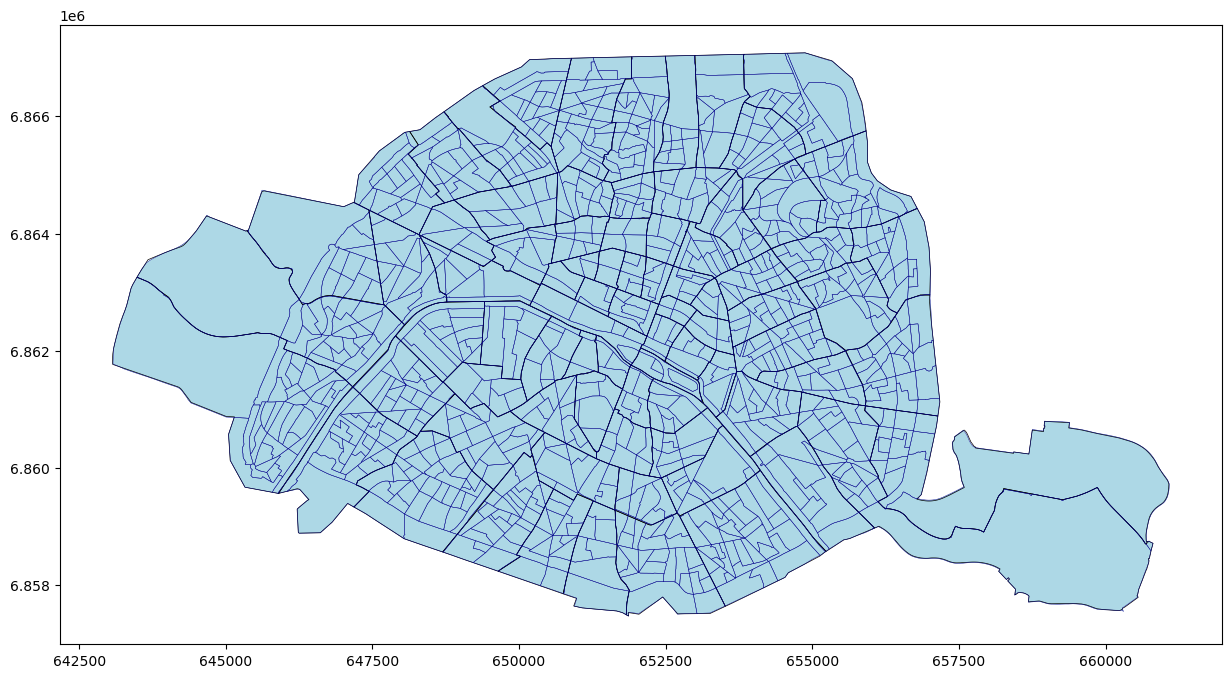

In [71]:
fig, ax = plt.subplots(1, figsize = (15, 15))
quartier.boundary.plot(ax = ax, linewidth = 0.5, color = "black")
iris.plot(ax = ax, color = "lightblue")
iris.boundary.plot(ax = ax, color = "darkblue", linewidth = 0.3)

The overall map does not tell us anything about how well the iris and the grands quartiers overlap. Thus, I am taking a single arrondissement and seeing it

In [78]:
# Define dataframes for the 15 arrondissement
arr15 = arr.loc[arr["c_ar"] == "15", :].copy()
iris15 = iris.loc[iris["INSEE_COM"] == "75115", :].copy()
quartier15 = quartier.loc[quartier["c_ar"] == "15", :].copy()

In [ ]:
fig, ax = plt.subplots(1, figsize = (15, 15))
quartier15.boundary.plot(ax = ax, linewidth = 0.5, color = "red")
iris15.plot(ax = ax, color = "lightblue")
iris15.boundary.plot(ax = ax, color = "blue", linewidth = 0.3)
arr15.boundary.plot(ax = ax, linewidth = 3, color = "black")

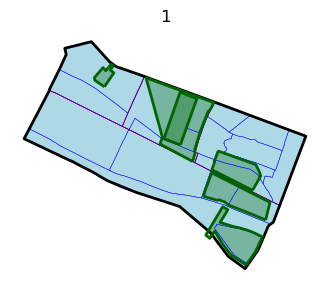

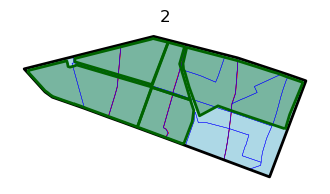

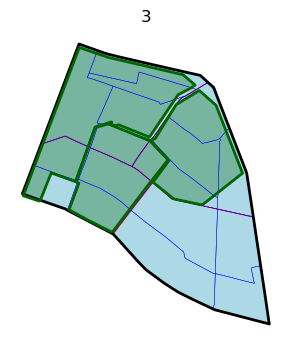

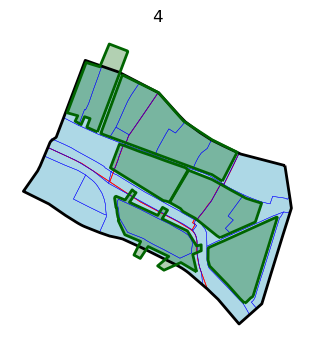

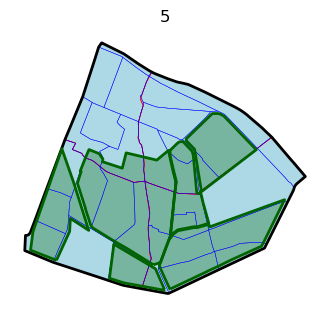

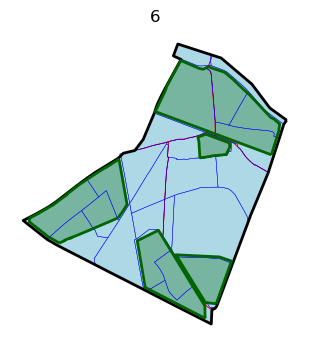

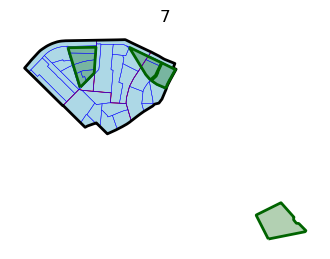

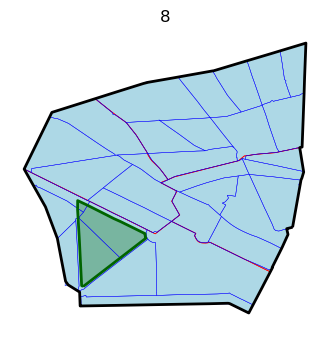

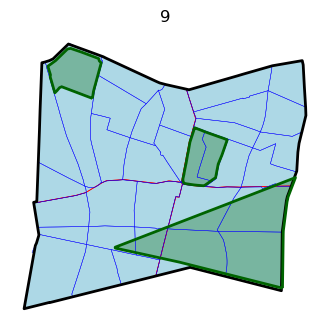

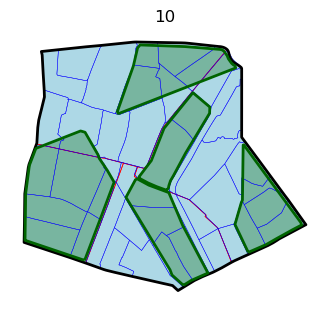

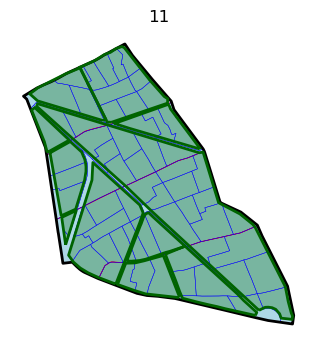

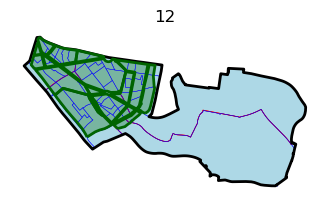

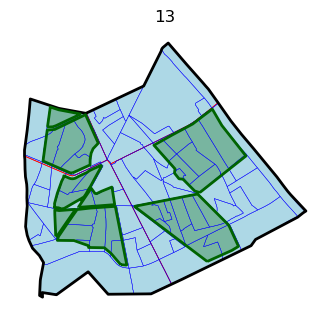

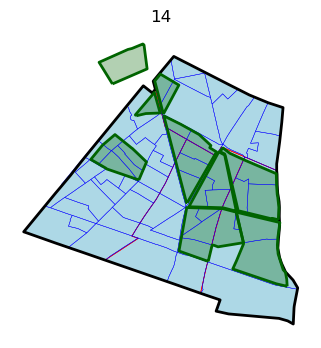

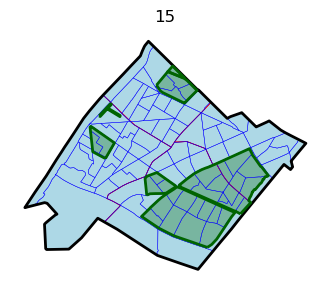

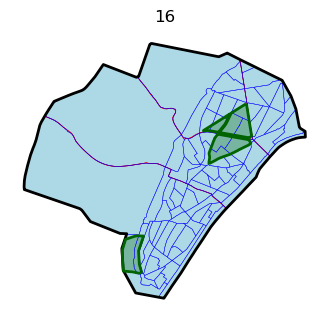

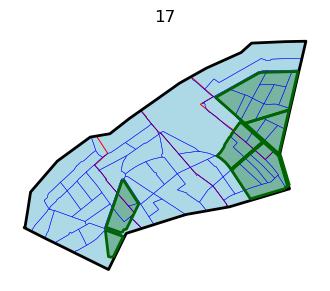

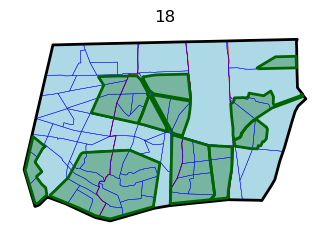

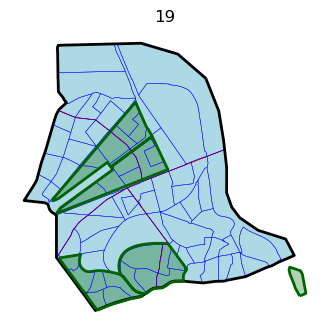

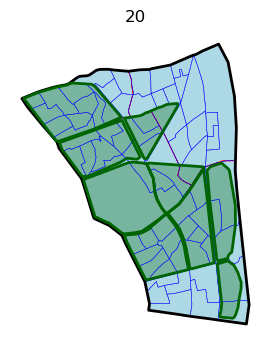

In [179]:
# Create a loop for each arrondissement
for i in np.arange(1, 21 ,1):
    if i < 10:
        i = str(i)
        j = "0"+str(i)
        fig, ax = plt.subplots(1, figsize = (4,4))
        quartier.loc[quartier["c_ar"] == i, :].boundary.plot(ax = ax, linewidth = 0.5, color = "red")
        iris.loc[iris["INSEE_COM"] == "751{}".format(j), :].plot(ax = ax, color = "lightblue")
        iris.loc[iris["INSEE_COM"] == "751{}".format(j), :].boundary.plot(ax = ax, color = "blue", linewidth = 0.3)
        arr.loc[arr["c_ar"] == i,:].boundary.plot(ax = ax, linewidth = 2, color = "black")
        zones.loc[zones["arrdt"] == i, :].plot(ax = ax, color = "darkgreen", alpha = 0.3)
        zones.loc[zones["arrdt"] == i, :].boundary.plot(ax = ax, color = "darkgreen", linewidth = 2)
        ax.axis("off")
        ax.set_title(i)
        
    else:
        i = str(i)
        fig, ax = plt.subplots(1, figsize = (4,4))
        quartier.loc[quartier["c_ar"] == i, :].boundary.plot(ax = ax, linewidth = 0.5, color = "red")
        iris.loc[iris["INSEE_COM"] == "751{}".format(i), :].plot(ax = ax, color = "lightblue")
        iris.loc[iris["INSEE_COM"] == "751{}".format(i), :].boundary.plot(ax = ax, color = "blue", linewidth = 0.3)
        arr.loc[arr["c_ar"] == i,:].boundary.plot(ax = ax, linewidth = 2, color = "black")
        zones.loc[zones["arrdt"] == i, :].plot(ax = ax, color = "darkgreen", alpha = 0.3)
        zones.loc[zones["arrdt"] == i, :].boundary.plot(ax = ax, color = "darkgreen", linewidth = 2)
        ax.axis("off")
        ax.set_title(i)
    

7TH, 14TH AND 19TH districts have, in the original dataset, 3 (1 each) slow zones which appears to be outside of their boundaries. This means they are most likely misclassified and I should reconsider what's going on in here.

### 2.2. Characterizing Slow Zones based on observables

### 2.2.1. Elementary and secondary schools

In [139]:
# Creating a more manageable variable for arrondissements
schools["arr"] = schools["arr_insee"].str[3:5]
highschools["arr"] = highschools["arr_insee"].str[3:5]

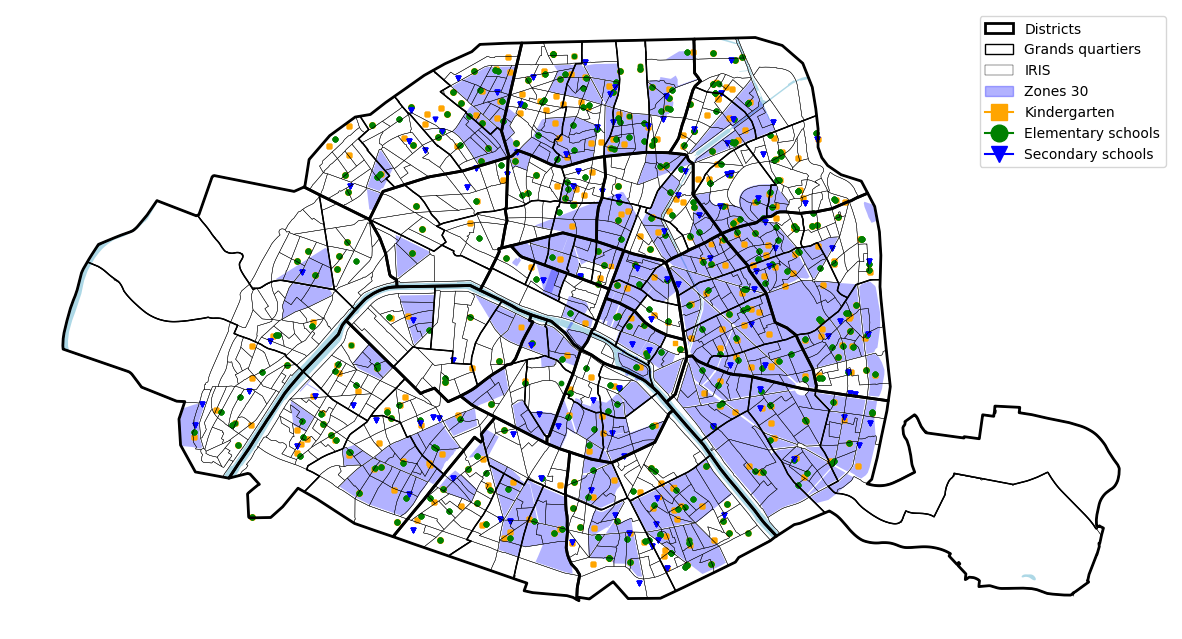

In [320]:
# Plotting schools and slow zones

# Generating a personalised legend
legend_schools = [Patch(facecolor="white", edgecolor="black", linewidth = 2,
                         label="Districts"),
                   Patch(facecolor="white", edgecolor="black", linewidth = 1,
                         label="Grands quartiers"),
                  Patch(facecolor="white", edgecolor="black", linewidth = 0.3,
                         label="IRIS"),
                   Patch(facecolor="blue", edgecolor="blue", alpha = 0.3,
                         label="Zones 30"),
                   Line2D([0], [0], marker="s", color="orange",label="Kindergarten",
                          markeredgecolor="orange", markersize=12),
                   Line2D([0], [0], marker="o", color="green",label="Elementary schools",
                          markeredgecolor="green", markersize=12),
                   Line2D([0], [0], marker="v", color="blue",label="Secondary schools",
                          markeredgecolor="blue", markersize=12)]


# Adding the different layers
fig, ax = plt.subplots(1, figsize = (15, 15))
arr.boundary.plot(ax = ax, linewidth = 2, color = "black")
eau.plot(ax = ax, color = "lightblue")
quartier.boundary.plot(ax = ax, color = "black", linewidth = 1)
iris.boundary.plot(ax = ax, color = "black", linewidth = 0.3)
zones.plot(ax = ax, color = "blue", alpha = 0.3)
kinder.plot(ax = ax, markersize = 10, marker = "s", color = "orange")
schools.plot(ax = ax, markersize = 10, marker = "o", color = "green")
highschools.plot(ax = ax, markersize = 10, marker = "v", color = "blue")
ax.axis("off")
# ax.add_artist(ScaleBar(1))
ax.legend(handles=legend_schools, loc="best")

#### Assigning each school to a slow zone

In [175]:
# Generate the variables
kinder["slow_zone"] = pd.Series([], dtype = "object")
kinder["slow_zone_year"] = pd.Series([], dtype = "object")

highschools["slow_zone"] = pd.Series([], dtype = "object")
highschools["slow_zone_year"] = pd.Series([], dtype = "object")

schools["slow_zone"] = pd.Series([], dtype = "object")
schools["slow_zone_year"] = pd.Series([], dtype = "object")

In [264]:
%%time

# First, kindergarten
for i in zones_non_na.index:
    kinder.loc[kinder["geometry"].within(zones_non_na.loc[i, "geometry"]), "slow_zone"] = zones_non_na.loc[i, "nom_zca"]
    kinder.loc[kinder["geometry"].within(zones_non_na.loc[i, "geometry"]), "slow_zone_year"] = zones_non_na.loc[i, "year"]
    kinder.loc[kinder["geometry"].within(zones_non_na.loc[i, "geometry"]), "slow_zone_year"] = zones_non_na.loc[i, "year"]
    

# Also, elementary schools
for i in zones_non_na.index:
    schools.loc[schools["geometry"].within(zones_non_na.loc[i, "geometry"]), "slow_zone"] = zones_non_na.loc[i, "nom_zca"]
    schools.loc[schools["geometry"].within(zones_non_na.loc[i, "geometry"]), "slow_zone_year"] = zones_non_na.loc[i, "year"]
    schools.loc[schools["geometry"].within(zones_non_na.loc[i, "geometry"]), "slow_zone_year"] = zones_non_na.loc[i, "year"]
    
    
# Then, secondary schools
for i in zones_non_na.index:
    highschools.loc[highschools["geometry"].within(zones_non_na.loc[i, "geometry"]), "slow_zone"] = zones_non_na.loc[i, "nom_zca"]
    highschools.loc[highschools["geometry"].within(zones_non_na.loc[i, "geometry"]), "slow_zone_year"] = zones_non_na.loc[i, "year"]

CPU times: user 238 ms, sys: 5.12 ms, total: 243 ms
Wall time: 245 ms


In [265]:
print(kinder["slow_zone"].isna().sum()/kinder.shape[0],
      schools["slow_zone"].isna().sum()/schools.shape[0],
      highschools["slow_zone"].isna().sum()/highschools.shape[0],
     schools.loc[schools["slow_zone_year"] == "2010",:].shape[0]/schools.shape[0])

0.5129334067143644 0.48374439461883406 0.5087719298245614 0.21132286995515695


### Results regarding schools:
 * 51% of kindergartens, 48% of elementary schools and 51% of secondary schools are inside a slow zone, which roughly makes half of the total. Taken at face value, this implies that the location of slow zones is not necessarily linked to more schools around, though more thorough analyses can be done.

### 2.2.2. Transport zones and stops

First of all, the transport data includes the whole Île de France, so I have to subset Paris before I start plotting it. Proceed hierarchically, starting from the zones de correspondances, zones d'arrêts, and ending with the arrêts. Metadata can be found [here](https://data.iledefrance-mobilites.fr/explore/dataset/referentiel-arret-tc-idf/information/).

In [195]:
# Import the referentiels, which do not have that much extra info
ref_zarr = pd.read_csv("transport/idf_mobilites/z_arrets/referentiel_z_arrets.csv", sep = ";")
ref_zcorr = pd.read_csv("transport/idf_mobilites/z_correspondances/referentiel_z_correspondances.csv", sep = ";")

In [186]:
# Explore the datasets: zones de correspondance
print(zcorr.columns)
print(zcorr.info())
zcorr.head()

Index(['nom', 'id_refa', 'unite_orga', 'commune', 'type_arret', 'type_objet',
       'geometry'],
      dtype='object')
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 15582 entries, 0 to 15581
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   nom         15582 non-null  object  
 1   id_refa     15582 non-null  int64   
 2   unite_orga  15582 non-null  int64   
 3   commune     15582 non-null  object  
 4   type_arret  15582 non-null  object  
 5   type_objet  15582 non-null  object  
 6   geometry    15582 non-null  geometry
dtypes: geometry(1), int64(2), object(4)
memory usage: 852.3+ KB
None


nom  id_refa  unite_orga commune     type_arret  \
0  Saussaie Beauclair - Domus    71908           0   93064   Arrêt de bus   
1            François Hanriot   425370           0   92050   Arrêt de bus   
2           Constant Coquelin    70027           0   94081  Arrêt de tram   
3           Place de l'Europe    61880           0   77260   Arrêt de bus   
4                       Péguy    68573           0   77171   Arrêt de bus   

  type_objet                                           geometry  
0  Reference  POLYGON ((661354.000 6864626.000, 661354.002 6...  
1  Reference  POLYGON ((642627.000 6867080.000, 642627.003 6...  
2  Reference  POLYGON ((655393.000 6853815.000, 655393.002 6...  
3  Reference  POLYGON ((717936.000 6824222.000, 717936.002 6...  
4  Reference  POLYGON ((686067.000 6865608.000, 686067.003 6...

In [187]:
# Explore the datasets: zones d'arrêts
print(zarr.columns)
print(zarr.info())
zarr.head()

Index(['nom', 'id_refa', 'unite_orga', 'commune', 'type_arret', 'idrefa_lda',
       'nom_lda', 'type_objet', 'geometry'],
      dtype='object')
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18155 entries, 0 to 18154
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   nom         18155 non-null  object  
 1   id_refa     18155 non-null  int64   
 2   unite_orga  18155 non-null  int64   
 3   commune     18155 non-null  object  
 4   type_arret  18155 non-null  object  
 5   idrefa_lda  18155 non-null  int64   
 6   nom_lda     18155 non-null  object  
 7   type_objet  18155 non-null  object  
 8   geometry    18155 non-null  geometry
dtypes: geometry(1), int64(3), object(5)
memory usage: 1.2+ MB
None


nom  id_refa  unite_orga commune    type_arret  idrefa_lda  \
0   Les Dix Arpents    42135           0   95641  Arrêt de bus       69355   
1  2 Rue de l'Etang    42137           0   78263  Arrêt de bus       63825   
2      21ème Siècle    42138           0   95277  Arrêt de bus       65318   
3     Trois Cornets    42139           0   78327  Arrêt de bus       65882   
4    Trois Quignons    42140           0   78251  Arrêt de bus       64529   

                       nom_lda type_objet  \
0              Les Dix Arpents  Reference   
1             2 Rue de l'Etang  Reference   
2                 21ème Siècle  Reference   
3  Trois Cornets / Jean Marion  Reference   
4               Trois Quignons  Reference   

                                            geometry  
0  POLYGON ((668921.575 6885317.818, 668921.717 6...  
1  POLYGON ((604182.000 6855251.000, 604182.000 6...  
2  POLYGON ((660332.000 6873970.000, 660331.037 6...  
3  POLYGON ((615279.000 6877229.000, 615278.037 6...  
4  POLYGON ((631296.000 6866119.000, 631295.037 6...

In [196]:
# Explore the datasets: arrêts
print(arrets.columns)
print(arrets.info())
arrets.head()

Index(['arrid', 'arrversion', 'arrcreated', 'arrchanged', 'arrname',
       'arrxepsg215', 'arryepsg215', 'arrtype', 'arrtown', 'arrpostalre',
       'arraccessib', 'arraudibles', 'arrvisualsi', 'arrfarezone', 'geometry'],
      dtype='object')
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 37773 entries, 0 to 37772
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   arrid        37773 non-null  object  
 1   arrversion   37773 non-null  object  
 2   arrcreated   37670 non-null  object  
 3   arrchanged   37773 non-null  object  
 4   arrname      37773 non-null  object  
 5   arrxepsg215  37773 non-null  object  
 6   arryepsg215  37773 non-null  object  
 7   arrtype      37773 non-null  object  
 8   arrtown      37773 non-null  object  
 9   arrpostalre  37773 non-null  object  
 10  arraccessib  37773 non-null  object  
 11  arraudibles  37773 non-null  object  
 12  arrvisualsi  37773 non-null  ob

arrid       arrversion                 arrcreated  \
0  427040  1466572-1466573  2017-10-12 02:00:00+02:00   
1   32172  1466531-1466532  2014-12-29 01:00:00+01:00   
2   32514  1466527-1466528  2014-12-29 16:31:51+01:00   
3   14174  1466524-1466525  2014-12-29 01:00:00+01:00   
4   39882  1466517-1466518  2014-12-29 01:00:00+01:00   

                  arrchanged                  arrname arrxepsg215 arryepsg215  \
0  2023-05-17 20:32:03+02:00        Roland Le Nestour      631173     6871540   
1  2023-05-17 20:10:19+02:00  Place Royale - Gambetta      633909     6866664   
2  2023-05-17 20:08:52+02:00  Place du MarÃ©chal Juin      614853     6875246   
3  2023-05-17 20:07:55+02:00             Paul Gauguin      629475     6875358   
4  2023-05-17 20:04:04+02:00       Parc de BÃ©themont      626762     6868504   

  arrtype                arrtown arrpostalre arraccessib arraudibles  \
0     bus                 Poissy       78498     unknown        true   
1     bus  Saint-Germain-en-Laye       78551     partial     partial   
2     bus                ÃpÃ´ne       78217     partial     partial   
3     bus  Chanteloup-les-Vignes       78138     unknown        true   
4     bus                 Poissy       78498     unknown        true   

  arrvisualsi arrfarezone                  geometry  
0        true           5  POINT (2.06044 48.94015)  
1     partial           4  POINT (2.09854 48.89659)  
2     partial           5  POINT (1.83694 48.97152)  
3        true           5  POINT (2.03663 48.97429)  
4        true           5  POINT (2.00075 48.91236)

The following code chunk can be ignored, as the change is already performed, and the data are saved accordingly. I nevertheless keep it for user readability
_____

In [223]:
######## This code chunk can be ignored #########
# Subset based on the code of the commune (respectively, "commune", "commune" and "arrpostalre")
# The names are simply overwritten, as I do not need info outside of Paris
paris_arr_codes = np.arange(75101, 75121, 1)

# Changing to string type
paris_arr_codes = list(map(str, paris_arr_codes))

arrets = arrets.loc[arrets["arrpostalre"].isin(paris_arr_codes),:].copy()
zarr = zarr.loc[zarr["commune"].isin(paris_arr_codes),:].copy()
zcorr = zcorr.loc[zcorr["commune"].isin(paris_arr_codes),:].copy()

# Save the data
arrets.to_file("transport/idf_mobilites/arrets/arrets_paris.geojson") # to avoid truncation of variables' names
zarr.to_file("transport/idf_mobilites/z_arrets/z_arrets_paris.shp")
zcorr.to_file("transport/idf_mobilites/z_correspondances/z_correspondances_paris.shp")

_____

Now, explore the degree of overlap, subsetting by arrondissements and by type of zones (i.e., metro, tram, bus, etc.)

In [235]:
# How many types of zones are there?
zcorr.loc[zcorr["type_arret"] == "Station de métro", :]
zarr.loc[zarr["type_arret"] == "Station de métro", :]

nom  id_refa  unite_orga commune  \
64                            Opéra    42237           0   75109   
448                         Dupleix    42871           0   75115   
451                           Duroc    42874           0   75107   
487                Église d'Auteuil    42947           0   75116   
504                          Europe    42972           0   75108   
...                             ...      ...         ...     ...   
16597   Saint-Sébastien - Froissart    45208           0   75103   
16598      Strasbourg - Saint-Denis    44909           0   75110   
16599  Trinité - d'Estienne d'Orves    45170           0   75109   
16847          Porte de la Chapelle   473459           0   75118   
18092       Saint-Philippe-du-Roule    44884           0   75108   

             type_arret  idrefa_lda                       nom_lda type_objet  \
64     Station de métro       71337                         Opéra  Reference   
448    Station de métro       71197                       Dupleix  Reference   
451    Station de métro       71159                         Duroc  Reference   
487    Station de métro       71166              Église d'Auteuil  Reference   
504    Station de métro       73617                        Europe  Reference   
...                 ...         ...                           ...        ...   
16597  Station de métro       71777   Saint-Sébastien - Froissart  Reference   
16598  Station de métro       73633      Strasbourg - Saint-Denis  Reference   
16599  Station de métro       71355  Trinité - d'Estienne d'Orves  Reference   
16847  Station de métro       72064          Porte de la Chapelle  Reference   
18092  Station de métro       71334       Saint-Philippe du Roule  Reference   

                                                geometry  
64     POLYGON ((651034.478 6863541.102, 651029.524 6...  
448    POLYGON ((648166.000 6861350.000, 648165.037 6...  
451    POLYGON ((649824.000 6860924.000, 649823.037 6...  
487    POLYGON ((646363.000 6861067.000, 646367.812 6...  
504    POLYGON ((650298.575 6864488.911, 650297.639 6...  
...                                                  ...  
16597  POLYGON ((653568.000 6862479.000, 653567.037 6...  
16598  POLYGON ((652593.000 6863421.000, 652592.037 6...  
16599  POLYGON ((651110.680 6864227.623, 651110.425 6...  
16847  POLYGON ((653025.279 6866597.913, 653026.917 6...  
18092  POLYGON ((649398.268 6863820.886, 649399.891 6...  

[247 rows x 9 columns]

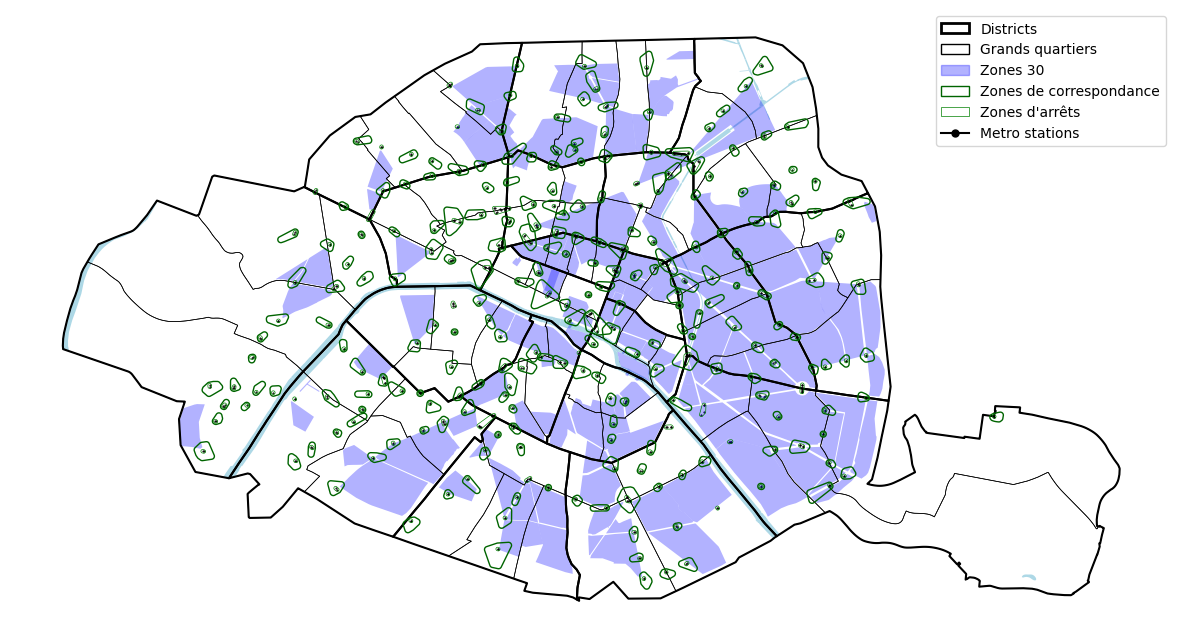

In [339]:
# Plot the metro stations' zones de correspondance and zones d'arrêt & arrêts

# Generating a personalised legend
legend_metro = [Patch(facecolor="white", edgecolor="black", linewidth = 2,
                         label="Districts"),
                   Patch(facecolor="white", edgecolor="black", linewidth = 1,
                         label="Grands quartiers"),
                   Patch(facecolor="blue", edgecolor="blue", alpha = 0.3,
                         label="Zones 30"),
                   Patch(facecolor="white", edgecolor="darkgreen", linewidth = 1,
                         label="Zones de correspondance"),
                   Patch(facecolor="white", edgecolor="green", linewidth = 0.5,
                         label="Zones d'arrêts"),
                   Line2D([0], [0], marker="o", color="black", label="Metro stations",
                          markeredgecolor="black", markersize=5)]

fig, ax = plt.subplots(1, figsize = (15, 15))
arr.boundary.plot(ax = ax, color = "black", linewidth = 1.5)
quartier.boundary.plot(ax = ax, color = "black", linewidth = 0.5)
eau.plot(ax = ax, color = "lightblue")
zcorr.loc[zcorr["type_arret"] == "Station de métro", :].boundary.plot(ax = ax, linewidth = 1, color = "darkgreen")
zarr.loc[zarr["type_arret"] == "Station de métro", :].boundary.plot(ax = ax, color = "green", linewidth = 0.5)
arrets.loc[arrets["arrtype"] == "metro", :].plot(ax = ax, color = "black", markersize = 0.3, marker = "o")
zones.plot(ax = ax, color = "blue", alpha = 0.3)
ax.axis("off")
#ax.add_artist(ScaleBar(1))
ax.legend(handles=legend_metro, loc="best")